This notebook is a reproduction of Udacity's RL notebook modified from CartpoleV0 to AcrobotV1: https://github.com/udacity/deep-learning/tree/master/reinforcement

In [1]:
import gym
import tensorflow as tf
import numpy as np

In [2]:
env = gym.make('Acrobot-v1')
env.reset()
rewards = []
for i in range(20):
    env.render()
    state,reward,done,info = env.step(env.action_space.sample())
    
    if done:
        rewards = []
        env.reset()
        
    rewards.append(reward)
    
env.render(close=True)
env.reset()
print(rewards)

[2017-08-01 17:17:09,158] Making new env: Acrobot-v1


[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [3]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [5]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 500                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', state_size=6, action_size=3,hidden_size=hidden_size, learning_rate=learning_rate)

In [7]:
# Initialize the simulation
env.reset()
# Take one random step
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [8]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                if t == 498:
                    #didn't reach the goal, so negative reward
                    next_state = np.ones(state.shape)*-1
                else:
                    next_state = np.zeros(state.shape)
                    
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/acrobot_solution.ckpt")


Episode: 1 Total reward: -479.0 Training loss: 0.9413 Explore P: 0.9537
Episode: 2 Total reward: -499.0 Training loss: 5.1093 Explore P: 0.9078
Episode: 3 Total reward: -499.0 Training loss: 1.7054 Explore P: 0.8641
Episode: 4 Total reward: -499.0 Training loss: 0.8168 Explore P: 0.8225
Episode: 5 Total reward: -499.0 Training loss: 1.0853 Explore P: 0.7829
Episode: 6 Total reward: -499.0 Training loss: 3.1173 Explore P: 0.7453
Episode: 7 Total reward: -499.0 Training loss: 1.5505 Explore P: 0.7095
Episode: 8 Total reward: -499.0 Training loss: 0.7290 Explore P: 0.6755
Episode: 9 Total reward: -499.0 Training loss: 0.7055 Explore P: 0.6431
Episode: 10 Total reward: -499.0 Training loss: 3.0092 Explore P: 0.6123
Episode: 11 Total reward: -499.0 Training loss: 0.9099 Explore P: 0.5830
Episode: 12 Total reward: -476.0 Training loss: 1.3506 Explore P: 0.5563
Episode: 13 Total reward: -499.0 Training loss: 3.8226 Explore P: 0.5297
Episode: 14 Total reward: -499.0 Training loss: 1.7003 Explo

Episode: 114 Total reward: -499.0 Training loss: 0.9436 Explore P: 0.0490
Episode: 115 Total reward: -420.0 Training loss: 1.5917 Explore P: 0.0474
Episode: 116 Total reward: -207.0 Training loss: 1.6074 Explore P: 0.0466
Episode: 117 Total reward: -135.0 Training loss: 0.6311 Explore P: 0.0461
Episode: 118 Total reward: -200.0 Training loss: 0.4856 Explore P: 0.0454
Episode: 119 Total reward: -156.0 Training loss: 0.7345 Explore P: 0.0449
Episode: 120 Total reward: -196.0 Training loss: 1.0380 Explore P: 0.0442
Episode: 121 Total reward: -446.0 Training loss: 0.6898 Explore P: 0.0427
Episode: 122 Total reward: -146.0 Training loss: 3.3540 Explore P: 0.0422
Episode: 123 Total reward: -174.0 Training loss: 1.4396 Explore P: 0.0416
Episode: 124 Total reward: -142.0 Training loss: 1.3263 Explore P: 0.0412
Episode: 125 Total reward: -170.0 Training loss: 0.4440 Explore P: 0.0407
Episode: 126 Total reward: -217.0 Training loss: 7.0689 Explore P: 0.0400
Episode: 127 Total reward: -119.0 Trai

Episode: 225 Total reward: -206.0 Training loss: 2.7624 Explore P: 0.0132
Episode: 226 Total reward: -157.0 Training loss: 6.1797 Explore P: 0.0132
Episode: 227 Total reward: -147.0 Training loss: 1.7378 Explore P: 0.0131
Episode: 228 Total reward: -158.0 Training loss: 1.2471 Explore P: 0.0131
Episode: 229 Total reward: -380.0 Training loss: 0.7959 Explore P: 0.0130
Episode: 230 Total reward: -139.0 Training loss: 3.5793 Explore P: 0.0129
Episode: 231 Total reward: -499.0 Training loss: 3.4724 Explore P: 0.0128
Episode: 232 Total reward: -113.0 Training loss: 2.7488 Explore P: 0.0128
Episode: 233 Total reward: -194.0 Training loss: 1.9145 Explore P: 0.0127
Episode: 234 Total reward: -168.0 Training loss: 10.2323 Explore P: 0.0127
Episode: 235 Total reward: -115.0 Training loss: 1.2925 Explore P: 0.0126
Episode: 236 Total reward: -124.0 Training loss: 3.6754 Explore P: 0.0126
Episode: 237 Total reward: -142.0 Training loss: 1.5741 Explore P: 0.0126
Episode: 238 Total reward: -161.0 Tra

Episode: 337 Total reward: -322.0 Training loss: 0.5626 Explore P: 0.0105
Episode: 338 Total reward: -103.0 Training loss: 7.6624 Explore P: 0.0105
Episode: 339 Total reward: -161.0 Training loss: 2.7100 Explore P: 0.0105
Episode: 340 Total reward: -193.0 Training loss: 3.1072 Explore P: 0.0105
Episode: 341 Total reward: -117.0 Training loss: 1.4642 Explore P: 0.0105
Episode: 342 Total reward: -280.0 Training loss: 4.9998 Explore P: 0.0104
Episode: 343 Total reward: -298.0 Training loss: 2.4580 Explore P: 0.0104
Episode: 344 Total reward: -143.0 Training loss: 1.1509 Explore P: 0.0104
Episode: 345 Total reward: -132.0 Training loss: 32.1379 Explore P: 0.0104
Episode: 346 Total reward: -165.0 Training loss: 1.4368 Explore P: 0.0104
Episode: 347 Total reward: -169.0 Training loss: 5.9489 Explore P: 0.0104
Episode: 348 Total reward: -112.0 Training loss: 21.2649 Explore P: 0.0104
Episode: 349 Total reward: -183.0 Training loss: 1.0419 Explore P: 0.0104
Episode: 350 Total reward: -161.0 Tr

Episode: 448 Total reward: -125.0 Training loss: 3.3192 Explore P: 0.0101
Episode: 449 Total reward: -167.0 Training loss: 1.4968 Explore P: 0.0101
Episode: 450 Total reward: -144.0 Training loss: 3.1988 Explore P: 0.0101
Episode: 451 Total reward: -168.0 Training loss: 0.4275 Explore P: 0.0101
Episode: 452 Total reward: -133.0 Training loss: 1.9122 Explore P: 0.0101
Episode: 453 Total reward: -145.0 Training loss: 1.1475 Explore P: 0.0101
Episode: 454 Total reward: -158.0 Training loss: 1.4961 Explore P: 0.0101
Episode: 455 Total reward: -115.0 Training loss: 17.2261 Explore P: 0.0101
Episode: 456 Total reward: -146.0 Training loss: 2.3662 Explore P: 0.0101
Episode: 457 Total reward: -150.0 Training loss: 1.9405 Explore P: 0.0101
Episode: 458 Total reward: -163.0 Training loss: 0.9821 Explore P: 0.0101
Episode: 459 Total reward: -149.0 Training loss: 1.2020 Explore P: 0.0101
Episode: 460 Total reward: -146.0 Training loss: 2.9399 Explore P: 0.0101
Episode: 461 Total reward: -132.0 Tra

Episode: 559 Total reward: -116.0 Training loss: 2.5066 Explore P: 0.0100
Episode: 560 Total reward: -128.0 Training loss: 2.4014 Explore P: 0.0100
Episode: 561 Total reward: -119.0 Training loss: 3.4395 Explore P: 0.0100
Episode: 562 Total reward: -122.0 Training loss: 17.3952 Explore P: 0.0100
Episode: 563 Total reward: -122.0 Training loss: 2.1106 Explore P: 0.0100
Episode: 564 Total reward: -127.0 Training loss: 3.4194 Explore P: 0.0100
Episode: 565 Total reward: -105.0 Training loss: 2.6391 Explore P: 0.0100
Episode: 566 Total reward: -100.0 Training loss: 2.9926 Explore P: 0.0100
Episode: 567 Total reward: -167.0 Training loss: 7.3354 Explore P: 0.0100
Episode: 568 Total reward: -109.0 Training loss: 0.5762 Explore P: 0.0100
Episode: 569 Total reward: -128.0 Training loss: 2.3437 Explore P: 0.0100
Episode: 570 Total reward: -127.0 Training loss: 0.6429 Explore P: 0.0100
Episode: 571 Total reward: -122.0 Training loss: 1.9324 Explore P: 0.0100
Episode: 572 Total reward: -128.0 Tra

Episode: 671 Total reward: -112.0 Training loss: 1.0809 Explore P: 0.0100
Episode: 672 Total reward: -119.0 Training loss: 1.2056 Explore P: 0.0100
Episode: 673 Total reward: -102.0 Training loss: 1.8140 Explore P: 0.0100
Episode: 674 Total reward: -103.0 Training loss: 1.3460 Explore P: 0.0100
Episode: 675 Total reward: -113.0 Training loss: 2.0082 Explore P: 0.0100
Episode: 676 Total reward: -99.0 Training loss: 1.3462 Explore P: 0.0100
Episode: 677 Total reward: -100.0 Training loss: 6.2949 Explore P: 0.0100
Episode: 678 Total reward: -127.0 Training loss: 2.6843 Explore P: 0.0100
Episode: 679 Total reward: -108.0 Training loss: 1.5017 Explore P: 0.0100
Episode: 680 Total reward: -129.0 Training loss: 1.0932 Explore P: 0.0100
Episode: 681 Total reward: -101.0 Training loss: 0.7731 Explore P: 0.0100
Episode: 682 Total reward: -131.0 Training loss: 3.2403 Explore P: 0.0100
Episode: 683 Total reward: -98.0 Training loss: 0.6956 Explore P: 0.0100
Episode: 684 Total reward: -141.0 Traini

Episode: 782 Total reward: -114.0 Training loss: 1.6925 Explore P: 0.0100
Episode: 783 Total reward: -111.0 Training loss: 3.0276 Explore P: 0.0100
Episode: 784 Total reward: -180.0 Training loss: 2.1714 Explore P: 0.0100
Episode: 785 Total reward: -167.0 Training loss: 3.1578 Explore P: 0.0100
Episode: 786 Total reward: -99.0 Training loss: 1.4213 Explore P: 0.0100
Episode: 787 Total reward: -102.0 Training loss: 0.8947 Explore P: 0.0100
Episode: 788 Total reward: -97.0 Training loss: 3.8908 Explore P: 0.0100
Episode: 789 Total reward: -99.0 Training loss: 2.4320 Explore P: 0.0100
Episode: 790 Total reward: -114.0 Training loss: 9.3193 Explore P: 0.0100
Episode: 791 Total reward: -129.0 Training loss: 4.6649 Explore P: 0.0100
Episode: 792 Total reward: -135.0 Training loss: 2.3141 Explore P: 0.0100
Episode: 793 Total reward: -110.0 Training loss: 1.4580 Explore P: 0.0100
Episode: 794 Total reward: -156.0 Training loss: 1.3674 Explore P: 0.0100
Episode: 795 Total reward: -151.0 Trainin

Episode: 894 Total reward: -120.0 Training loss: 0.9888 Explore P: 0.0100
Episode: 895 Total reward: -126.0 Training loss: 1.3999 Explore P: 0.0100
Episode: 896 Total reward: -110.0 Training loss: 1.7160 Explore P: 0.0100
Episode: 897 Total reward: -103.0 Training loss: 2.3902 Explore P: 0.0100
Episode: 898 Total reward: -99.0 Training loss: 2.1294 Explore P: 0.0100
Episode: 899 Total reward: -109.0 Training loss: 14.2233 Explore P: 0.0100
Episode: 900 Total reward: -126.0 Training loss: 1.7898 Explore P: 0.0100
Episode: 901 Total reward: -145.0 Training loss: 1.8835 Explore P: 0.0100
Episode: 902 Total reward: -89.0 Training loss: 3.2515 Explore P: 0.0100
Episode: 903 Total reward: -127.0 Training loss: 3.2419 Explore P: 0.0100
Episode: 904 Total reward: -146.0 Training loss: 4.2966 Explore P: 0.0100
Episode: 905 Total reward: -97.0 Training loss: 2.8245 Explore P: 0.0100
Episode: 906 Total reward: -85.0 Training loss: 0.9548 Explore P: 0.0100
Episode: 907 Total reward: -104.0 Trainin

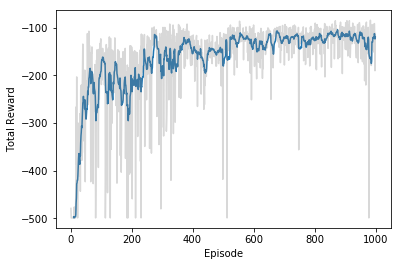

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [14]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        reward_total = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            reward_total += reward
            if done:
                print("Steps: {} Reward: {}".format(t,reward_total))
                t = test_max_steps
                env.reset()
                # Take one random step
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1
env.render(close=True)

INFO:tensorflow:Restoring parameters from checkpoints/acrobot_solution.ckpt


[2017-08-01 17:25:58,909] Restoring parameters from checkpoints/acrobot_solution.ckpt


Steps: 109 Reward: -109.0
Steps: 106 Reward: -106.0
Steps: 133 Reward: -133.0
Steps: 115 Reward: -115.0
Steps: 127 Reward: -127.0
Steps: 130 Reward: -130.0
Steps: 127 Reward: -127.0
Steps: 115 Reward: -115.0
Steps: 141 Reward: -141.0
